##Nuclei detection with Mask RCNN

In [54]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

##Configuration

In [55]:
class NucleiConfig(Config):
    """Configuration for training on the nuclei dataset.
    Derives from the base Config class and overrides values specific
    to the toy nuclei dataset.
    """
    # Give the configuration a recognizable name
    NAME = "nuclei"

    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    # Use the highest number that the GPU/CPU can handel ?
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 nuclei class

    # Set the limits of the small side
    # the large side, and that determines the image shape.
    # Image are resized such that the smallest side is >= the min dim 
    # the longest side is <= the max dim
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Number of ROI per image to feed the classifier. The mask RCNN paper 
    # use 512 but often the RPN doesn't generate enough positive proposal
    # to fill this and keep a positive:negative ratio of 1:3.
    # The mean is about 60? choose 200 to keep the positive rate 33%
    TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # Max number of final detection, adjust according to the distribution
    DETECTION_MAX_INSTANCES = 380
    
config = NucleiConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        380
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Dataset

Create a nuclei dataset



In [56]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [57]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids
        

In [58]:
#load the first 10 images
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_ids[0:450])
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, train_ids[450:])
dataset_val.prepare()

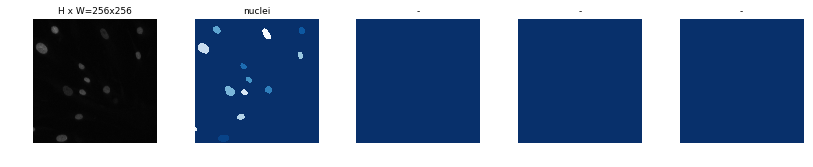

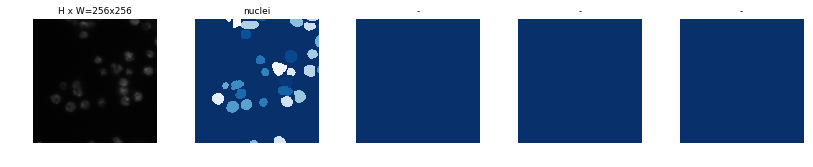

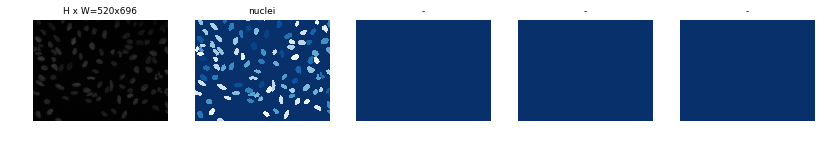

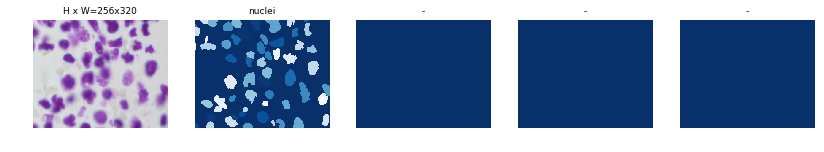

In [59]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


##Create model

In [60]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [61]:
# Which weights to start with? Used coco weights? 
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [62]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180319T0014/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/100 [..............................] - ETA: 43:49 - loss: 5.5596 - rpn_class_loss: 1.1264 - rpn_bbox_loss: 2.0088 - mrcnn_class_loss: 0.2798 - mrcnn_bbox_loss: 1.3748 - mrcnn_mask_loss: 0.7698

  2/100 [..............................] - ETA: 38:26 - loss: 5.4174 - rpn_class_loss: 1.1452 - rpn_bbox_loss: 1.9567 - mrcnn_class_loss: 0.3343 - mrcnn_bbox_loss: 1.2547 - mrcnn_mask_loss: 0.7265

  3/100 [..............................] - ETA: 35:04 - loss: 5.5866 - rpn_class_loss: 0.9701 - rpn_bbox_loss: 2.4736 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 1.1744 - mrcnn_mask_loss: 0.7167

  4/100 [>.............................] - ETA: 31:51 - loss: 5.8806 - rpn_class_loss: 1.1276 - rpn_bbox_loss: 2.5967 - mrcnn_class_loss: 0.3321 - mrcnn_bbox_loss: 1.1116 - mrcnn_mask_loss: 0.7126

  5/100 [>.............................] - ETA: 29:23 - loss: 5.5372 - rpn_class_loss: 1.0053 - rpn_bbox_loss: 2.4331 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 1.1288 - mrcnn_mask_loss: 0.6921

  6/100 [>.............................] - ETA: 27:38 - loss: 6.1558 - rpn_class_loss: 1.8145 - rpn_bbox_loss: 2.2738 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 1.1174 - mrcnn_mask_loss: 0.6909

  7/100 [=>............................] - ETA: 26:32 - loss: 6.6044 - rpn_class_loss: 2.3973 - rpn_bbox_loss: 2.1672 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 1.0886 - mrcnn_mask_loss: 0.7024

  8/100 [=>............................] - ETA: 25:26 - loss: 6.5152 - rpn_class_loss: 2.4664 - rpn_bbox_loss: 2.0552 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 1.0459 - mrcnn_mask_loss: 0.7061

  9/100 [=>............................] - ETA: 24:34 - loss: 6.1345 - rpn_class_loss: 2.2581 - rpn_bbox_loss: 1.9440 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 1.0058 - mrcnn_mask_loss: 0.6993

 10/100 [==>...........................] - ETA: 23:50 - loss: 5.9546 - rpn_class_loss: 2.1735 - rpn_bbox_loss: 1.8744 - mrcnn_class_loss: 0.2246 - mrcnn_bbox_loss: 0.9857 - mrcnn_mask_loss: 0.6964

 11/100 [==>...........................] - ETA: 23:13 - loss: 5.5788 - rpn_class_loss: 1.9863 - rpn_bbox_loss: 1.7633 - mrcnn_class_loss: 0.2104 - mrcnn_bbox_loss: 0.9450 - mrcnn_mask_loss: 0.6739

 12/100 [==>...........................] - ETA: 22:38 - loss: 5.4066 - rpn_class_loss: 1.8626 - rpn_bbox_loss: 1.7303 - mrcnn_class_loss: 0.1991 - mrcnn_bbox_loss: 0.9280 - mrcnn_mask_loss: 0.6866

 13/100 [==>...........................] - ETA: 22:06 - loss: 5.3434 - rpn_class_loss: 1.7531 - rpn_bbox_loss: 1.7602 - mrcnn_class_loss: 0.1960 - mrcnn_bbox_loss: 0.9327 - mrcnn_mask_loss: 0.7013

 14/100 [===>..........................] - ETA: 21:37 - loss: 5.2462 - rpn_class_loss: 1.6893 - rpn_bbox_loss: 1.7154 - mrcnn_class_loss: 0.2030 - mrcnn_bbox_loss: 0.9422 - mrcnn_mask_loss: 0.6963

 15/100 [===>..........................] - ETA: 21:09 - loss: 5.0847 - rpn_class_loss: 1.6184 - rpn_bbox_loss: 1.6650 - mrcnn_class_loss: 0.1917 - mrcnn_bbox_loss: 0.9248 - mrcnn_mask_loss: 0.6847

 16/100 [===>..........................] - ETA: 20:46 - loss: 4.9546 - rpn_class_loss: 1.5615 - rpn_bbox_loss: 1.6210 - mrcnn_class_loss: 0.1946 - mrcnn_bbox_loss: 0.9027 - mrcnn_mask_loss: 0.6748

 17/100 [====>.........................] - ETA: 20:22 - loss: 4.8703 - rpn_class_loss: 1.5148 - rpn_bbox_loss: 1.5831 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.8992 - mrcnn_mask_loss: 0.6684

 18/100 [====>.........................] - ETA: 20:00 - loss: 4.7556 - rpn_class_loss: 1.4811 - rpn_bbox_loss: 1.5351 - mrcnn_class_loss: 0.2042 - mrcnn_bbox_loss: 0.8761 - mrcnn_mask_loss: 0.6592

 19/100 [====>.........................] - ETA: 19:37 - loss: 4.6880 - rpn_class_loss: 1.4425 - rpn_bbox_loss: 1.5416 - mrcnn_class_loss: 0.1952 - mrcnn_bbox_loss: 0.8596 - mrcnn_mask_loss: 0.6491

 20/100 [=====>........................] - ETA: 19:17 - loss: 4.6116 - rpn_class_loss: 1.3859 - rpn_bbox_loss: 1.5444 - mrcnn_class_loss: 0.1913 - mrcnn_bbox_loss: 0.8476 - mrcnn_mask_loss: 0.6424

 21/100 [=====>........................] - ETA: 18:59 - loss: 4.5350 - rpn_class_loss: 1.3416 - rpn_bbox_loss: 1.5150 - mrcnn_class_loss: 0.1969 - mrcnn_bbox_loss: 0.8392 - mrcnn_mask_loss: 0.6425

 22/100 [=====>........................] - ETA: 18:41 - loss: 4.5783 - rpn_class_loss: 1.3087 - rpn_bbox_loss: 1.5653 - mrcnn_class_loss: 0.1889 - mrcnn_bbox_loss: 0.8655 - mrcnn_mask_loss: 0.6500

ERROR:root:Error processing image {'id': 141, 'source': 'nuclei', 'path': './input/stage1_train/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288/images/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288.png', 'maskpath': './input/stage1_train/a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

 23/100 [=====>........................] - ETA: 18:36 - loss: 4.4717 - rpn_class_loss: 1.2570 - rpn_bbox_loss: 1.5217 - mrcnn_class_loss: 0.1823 - mrcnn_bbox_loss: 0.8657 - mrcnn_mask_loss: 0.6450

 24/100 [======>.......................] - ETA: 18:21 - loss: 4.3701 - rpn_class_loss: 1.2088 - rpn_bbox_loss: 1.4910 - mrcnn_class_loss: 0.1790 - mrcnn_bbox_loss: 0.8506 - mrcnn_mask_loss: 0.6408

 25/100 [======>.......................] - ETA: 18:05 - loss: 4.2819 - rpn_class_loss: 1.1663 - rpn_bbox_loss: 1.4729 - mrcnn_class_loss: 0.1737 - mrcnn_bbox_loss: 0.8342 - mrcnn_mask_loss: 0.6348

 26/100 [======>.......................] - ETA: 17:50 - loss: 4.2194 - rpn_class_loss: 1.1312 - rpn_bbox_loss: 1.4553 - mrcnn_class_loss: 0.1777 - mrcnn_bbox_loss: 0.8265 - mrcnn_mask_loss: 0.6288

 27/100 [=======>......................] - ETA: 17:35 - loss: 4.1912 - rpn_class_loss: 1.1189 - rpn_bbox_loss: 1.4414 - mrcnn_class_loss: 0.1813 - mrcnn_bbox_loss: 0.8228 - mrcnn_mask_loss: 0.6268

 28/100 [=======>......................] - ETA: 17:20 - loss: 4.1251 - rpn_class_loss: 1.0878 - rpn_bbox_loss: 1.4281 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 0.8118 - mrcnn_mask_loss: 0.6209

 29/100 [=======>......................] - ETA: 17:05 - loss: 4.0712 - rpn_class_loss: 1.0581 - rpn_bbox_loss: 1.4154 - mrcnn_class_loss: 0.1727 - mrcnn_bbox_loss: 0.8038 - mrcnn_mask_loss: 0.6212

 30/100 [========>.....................] - ETA: 16:51 - loss: 4.0359 - rpn_class_loss: 1.0433 - rpn_bbox_loss: 1.3943 - mrcnn_class_loss: 0.1817 - mrcnn_bbox_loss: 0.7970 - mrcnn_mask_loss: 0.6196

 31/100 [========>.....................] - ETA: 16:36 - loss: 3.9896 - rpn_class_loss: 1.0229 - rpn_bbox_loss: 1.3827 - mrcnn_class_loss: 0.1812 - mrcnn_bbox_loss: 0.7870 - mrcnn_mask_loss: 0.6158

 32/100 [========>.....................] - ETA: 16:21 - loss: 3.9550 - rpn_class_loss: 1.0036 - rpn_bbox_loss: 1.3756 - mrcnn_class_loss: 0.1795 - mrcnn_bbox_loss: 0.7822 - mrcnn_mask_loss: 0.6140

 33/100 [========>.....................] - ETA: 16:06 - loss: 3.9012 - rpn_class_loss: 0.9763 - rpn_bbox_loss: 1.3610 - mrcnn_class_loss: 0.1749 - mrcnn_bbox_loss: 0.7773 - mrcnn_mask_loss: 0.6117

 34/100 [=========>....................] - ETA: 15:51 - loss: 3.8778 - rpn_class_loss: 0.9666 - rpn_bbox_loss: 1.3493 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.7731 - mrcnn_mask_loss: 0.6120

 35/100 [=========>....................] - ETA: 15:36 - loss: 3.8834 - rpn_class_loss: 0.9792 - rpn_bbox_loss: 1.3360 - mrcnn_class_loss: 0.1846 - mrcnn_bbox_loss: 0.7719 - mrcnn_mask_loss: 0.6117

 36/100 [=========>....................] - ETA: 15:21 - loss: 3.8629 - rpn_class_loss: 0.9674 - rpn_bbox_loss: 1.3253 - mrcnn_class_loss: 0.1933 - mrcnn_bbox_loss: 0.7664 - mrcnn_mask_loss: 0.6106

 37/100 [==========>...................] - ETA: 15:06 - loss: 3.8236 - rpn_class_loss: 0.9485 - rpn_bbox_loss: 1.3212 - mrcnn_class_loss: 0.1897 - mrcnn_bbox_loss: 0.7593 - mrcnn_mask_loss: 0.6048

 38/100 [==========>...................] - ETA: 14:52 - loss: 3.8191 - rpn_class_loss: 0.9338 - rpn_bbox_loss: 1.3294 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.7620 - mrcnn_mask_loss: 0.6054

 39/100 [==========>...................] - ETA: 14:37 - loss: 3.7916 - rpn_class_loss: 0.9182 - rpn_bbox_loss: 1.3194 - mrcnn_class_loss: 0.1875 - mrcnn_bbox_loss: 0.7615 - mrcnn_mask_loss: 0.6050

 40/100 [===========>..................] - ETA: 14:21 - loss: 3.7675 - rpn_class_loss: 0.9073 - rpn_bbox_loss: 1.3047 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.7584 - mrcnn_mask_loss: 0.6046

 41/100 [===========>..................] - ETA: 14:06 - loss: 3.7185 - rpn_class_loss: 0.8912 - rpn_bbox_loss: 1.2905 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.7460 - mrcnn_mask_loss: 0.6023

 42/100 [===========>..................] - ETA: 13:51 - loss: 3.6810 - rpn_class_loss: 0.8763 - rpn_bbox_loss: 1.2743 - mrcnn_class_loss: 0.1884 - mrcnn_bbox_loss: 0.7417 - mrcnn_mask_loss: 0.6003

 43/100 [===========>..................] - ETA: 13:36 - loss: 3.7076 - rpn_class_loss: 0.8755 - rpn_bbox_loss: 1.2977 - mrcnn_class_loss: 0.1855 - mrcnn_bbox_loss: 0.7456 - mrcnn_mask_loss: 0.6034

 44/100 [============>.................] - ETA: 13:21 - loss: 3.6738 - rpn_class_loss: 0.8642 - rpn_bbox_loss: 1.2876 - mrcnn_class_loss: 0.1836 - mrcnn_bbox_loss: 0.7386 - mrcnn_mask_loss: 0.5997

 45/100 [============>.................] - ETA: 13:06 - loss: 3.6598 - rpn_class_loss: 0.8595 - rpn_bbox_loss: 1.2777 - mrcnn_class_loss: 0.1904 - mrcnn_bbox_loss: 0.7340 - mrcnn_mask_loss: 0.5982

 46/100 [============>.................] - ETA: 12:51 - loss: 3.6223 - rpn_class_loss: 0.8469 - rpn_bbox_loss: 1.2672 - mrcnn_class_loss: 0.1882 - mrcnn_bbox_loss: 0.7256 - mrcnn_mask_loss: 0.5943

 47/100 [=============>................] - ETA: 12:37 - loss: 3.6057 - rpn_class_loss: 0.8374 - rpn_bbox_loss: 1.2642 - mrcnn_class_loss: 0.1892 - mrcnn_bbox_loss: 0.7225 - mrcnn_mask_loss: 0.5924

 48/100 [=============>................] - ETA: 12:22 - loss: 3.5720 - rpn_class_loss: 0.8257 - rpn_bbox_loss: 1.2551 - mrcnn_class_loss: 0.1874 - mrcnn_bbox_loss: 0.7140 - mrcnn_mask_loss: 0.5897

 49/100 [=============>................] - ETA: 12:08 - loss: 3.5363 - rpn_class_loss: 0.8116 - rpn_bbox_loss: 1.2456 - mrcnn_class_loss: 0.1851 - mrcnn_bbox_loss: 0.7071 - mrcnn_mask_loss: 0.5870

 50/100 [==============>...............] - ETA: 11:54 - loss: 3.4989 - rpn_class_loss: 0.7980 - rpn_bbox_loss: 1.2332 - mrcnn_class_loss: 0.1817 - mrcnn_bbox_loss: 0.7009 - mrcnn_mask_loss: 0.5850

 51/100 [==============>...............] - ETA: 11:39 - loss: 3.4848 - rpn_class_loss: 0.7859 - rpn_bbox_loss: 1.2297 - mrcnn_class_loss: 0.1799 - mrcnn_bbox_loss: 0.7005 - mrcnn_mask_loss: 0.5888

 52/100 [==============>...............] - ETA: 11:24 - loss: 3.4591 - rpn_class_loss: 0.7741 - rpn_bbox_loss: 1.2189 - mrcnn_class_loss: 0.1783 - mrcnn_bbox_loss: 0.7007 - mrcnn_mask_loss: 0.5870

 53/100 [==============>...............] - ETA: 11:09 - loss: 3.4390 - rpn_class_loss: 0.7636 - rpn_bbox_loss: 1.2090 - mrcnn_class_loss: 0.1802 - mrcnn_bbox_loss: 0.6983 - mrcnn_mask_loss: 0.5879

 54/100 [===============>..............] - ETA: 10:54 - loss: 3.4186 - rpn_class_loss: 0.7543 - rpn_bbox_loss: 1.2057 - mrcnn_class_loss: 0.1783 - mrcnn_bbox_loss: 0.6949 - mrcnn_mask_loss: 0.5855

 55/100 [===============>..............] - ETA: 10:39 - loss: 3.4148 - rpn_class_loss: 0.7558 - rpn_bbox_loss: 1.2003 - mrcnn_class_loss: 0.1797 - mrcnn_bbox_loss: 0.6949 - mrcnn_mask_loss: 0.5840

 56/100 [===============>..............] - ETA: 10:25 - loss: 3.4009 - rpn_class_loss: 0.7510 - rpn_bbox_loss: 1.1920 - mrcnn_class_loss: 0.1811 - mrcnn_bbox_loss: 0.6926 - mrcnn_mask_loss: 0.5841

 57/100 [================>.............] - ETA: 10:10 - loss: 3.3744 - rpn_class_loss: 0.7389 - rpn_bbox_loss: 1.1811 - mrcnn_class_loss: 0.1781 - mrcnn_bbox_loss: 0.6935 - mrcnn_mask_loss: 0.5828

 58/100 [================>.............] - ETA: 9:55 - loss: 3.3604 - rpn_class_loss: 0.7328 - rpn_bbox_loss: 1.1756 - mrcnn_class_loss: 0.1789 - mrcnn_bbox_loss: 0.6924 - mrcnn_mask_loss: 0.5808 

 59/100 [================>.............] - ETA: 9:40 - loss: 3.3317 - rpn_class_loss: 0.7223 - rpn_bbox_loss: 1.1644 - mrcnn_class_loss: 0.1762 - mrcnn_bbox_loss: 0.6898 - mrcnn_mask_loss: 0.5789

 60/100 [=================>............] - ETA: 9:25 - loss: 3.3067 - rpn_class_loss: 0.7127 - rpn_bbox_loss: 1.1552 - mrcnn_class_loss: 0.1738 - mrcnn_bbox_loss: 0.6898 - mrcnn_mask_loss: 0.5753

 61/100 [=================>............] - ETA: 9:11 - loss: 3.2905 - rpn_class_loss: 0.7031 - rpn_bbox_loss: 1.1514 - mrcnn_class_loss: 0.1724 - mrcnn_bbox_loss: 0.6854 - mrcnn_mask_loss: 0.5782

ERROR:root:Error processing image {'id': 153, 'source': 'nuclei', 'path': './input/stage1_train/54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12/images/54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12.png', 'maskpath': './input/stage1_train/54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

 62/100 [=================>............] - ETA: 8:56 - loss: 3.2648 - rpn_class_loss: 0.6942 - rpn_bbox_loss: 1.1434 - mrcnn_class_loss: 0.1710 - mrcnn_bbox_loss: 0.6807 - mrcnn_mask_loss: 0.5756

 63/100 [=================>............] - ETA: 8:42 - loss: 3.2449 - rpn_class_loss: 0.6864 - rpn_bbox_loss: 1.1386 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.6768 - mrcnn_mask_loss: 0.5731

 64/100 [==================>...........] - ETA: 8:27 - loss: 3.2618 - rpn_class_loss: 0.6914 - rpn_bbox_loss: 1.1340 - mrcnn_class_loss: 0.1818 - mrcnn_bbox_loss: 0.6819 - mrcnn_mask_loss: 0.5726

 65/100 [==================>...........] - ETA: 8:13 - loss: 3.2696 - rpn_class_loss: 0.6939 - rpn_bbox_loss: 1.1306 - mrcnn_class_loss: 0.1880 - mrcnn_bbox_loss: 0.6853 - mrcnn_mask_loss: 0.5717

 66/100 [==================>...........] - ETA: 7:58 - loss: 3.2458 - rpn_class_loss: 0.6853 - rpn_bbox_loss: 1.1236 - mrcnn_class_loss: 0.1859 - mrcnn_bbox_loss: 0.6813 - mrcnn_mask_loss: 0.5697

 67/100 [===================>..........] - ETA: 7:44 - loss: 3.2680 - rpn_class_loss: 0.6867 - rpn_bbox_loss: 1.1424 - mrcnn_class_loss: 0.1835 - mrcnn_bbox_loss: 0.6833 - mrcnn_mask_loss: 0.5722

 68/100 [===================>..........] - ETA: 7:29 - loss: 3.2555 - rpn_class_loss: 0.6813 - rpn_bbox_loss: 1.1357 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 0.6814 - mrcnn_mask_loss: 0.5714

 69/100 [===================>..........] - ETA: 7:15 - loss: 3.2303 - rpn_class_loss: 0.6729 - rpn_bbox_loss: 1.1280 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.6752 - mrcnn_mask_loss: 0.5703

 70/100 [====================>.........] - ETA: 7:00 - loss: 3.2176 - rpn_class_loss: 0.6682 - rpn_bbox_loss: 1.1244 - mrcnn_class_loss: 0.1832 - mrcnn_bbox_loss: 0.6720 - mrcnn_mask_loss: 0.5698

 71/100 [====================>.........] - ETA: 6:46 - loss: 3.2162 - rpn_class_loss: 0.6688 - rpn_bbox_loss: 1.1197 - mrcnn_class_loss: 0.1846 - mrcnn_bbox_loss: 0.6724 - mrcnn_mask_loss: 0.5707

 72/100 [====================>.........] - ETA: 6:32 - loss: 3.2029 - rpn_class_loss: 0.6638 - rpn_bbox_loss: 1.1197 - mrcnn_class_loss: 0.1838 - mrcnn_bbox_loss: 0.6677 - mrcnn_mask_loss: 0.5679

 73/100 [====================>.........] - ETA: 6:18 - loss: 3.1837 - rpn_class_loss: 0.6565 - rpn_bbox_loss: 1.1154 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.6650 - mrcnn_mask_loss: 0.5646

 74/100 [=====================>........] - ETA: 6:03 - loss: 3.1612 - rpn_class_loss: 0.6487 - rpn_bbox_loss: 1.1092 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.6604 - mrcnn_mask_loss: 0.5628

 75/100 [=====================>........] - ETA: 5:49 - loss: 3.1470 - rpn_class_loss: 0.6436 - rpn_bbox_loss: 1.1086 - mrcnn_class_loss: 0.1787 - mrcnn_bbox_loss: 0.6553 - mrcnn_mask_loss: 0.5608

 76/100 [=====================>........] - ETA: 5:35 - loss: 3.1270 - rpn_class_loss: 0.6363 - rpn_bbox_loss: 1.1037 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.6505 - mrcnn_mask_loss: 0.5598

 77/100 [======================>.......] - ETA: 5:21 - loss: 3.1046 - rpn_class_loss: 0.6294 - rpn_bbox_loss: 1.0975 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.6462 - mrcnn_mask_loss: 0.5569

 78/100 [======================>.......] - ETA: 5:07 - loss: 3.0924 - rpn_class_loss: 0.6246 - rpn_bbox_loss: 1.0932 - mrcnn_class_loss: 0.1744 - mrcnn_bbox_loss: 0.6448 - mrcnn_mask_loss: 0.5553

 79/100 [======================>.......] - ETA: 4:52 - loss: 3.0817 - rpn_class_loss: 0.6204 - rpn_bbox_loss: 1.0886 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.6440 - mrcnn_mask_loss: 0.5543

 80/100 [=======================>......] - ETA: 4:38 - loss: 3.0666 - rpn_class_loss: 0.6155 - rpn_bbox_loss: 1.0847 - mrcnn_class_loss: 0.1735 - mrcnn_bbox_loss: 0.6404 - mrcnn_mask_loss: 0.5525

 81/100 [=======================>......] - ETA: 4:24 - loss: 3.0504 - rpn_class_loss: 0.6095 - rpn_bbox_loss: 1.0814 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.6365 - mrcnn_mask_loss: 0.5508

 82/100 [=======================>......] - ETA: 4:10 - loss: 3.0332 - rpn_class_loss: 0.6045 - rpn_bbox_loss: 1.0771 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.6321 - mrcnn_mask_loss: 0.5486

 83/100 [=======================>......] - ETA: 3:56 - loss: 3.0181 - rpn_class_loss: 0.5988 - rpn_bbox_loss: 1.0723 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.6290 - mrcnn_mask_loss: 0.5478

 84/100 [========================>.....] - ETA: 3:42 - loss: 3.0124 - rpn_class_loss: 0.5962 - rpn_bbox_loss: 1.0680 - mrcnn_class_loss: 0.1726 - mrcnn_bbox_loss: 0.6279 - mrcnn_mask_loss: 0.5477

 85/100 [========================>.....] - ETA: 3:28 - loss: 3.0019 - rpn_class_loss: 0.5930 - rpn_bbox_loss: 1.0669 - mrcnn_class_loss: 0.1714 - mrcnn_bbox_loss: 0.6251 - mrcnn_mask_loss: 0.5456

 86/100 [========================>.....] - ETA: 3:14 - loss: 2.9890 - rpn_class_loss: 0.5887 - rpn_bbox_loss: 1.0623 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.6223 - mrcnn_mask_loss: 0.5444

 87/100 [=========================>....] - ETA: 3:00 - loss: 2.9756 - rpn_class_loss: 0.5839 - rpn_bbox_loss: 1.0575 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.6208 - mrcnn_mask_loss: 0.5432

 88/100 [=========================>....] - ETA: 2:46 - loss: 2.9638 - rpn_class_loss: 0.5807 - rpn_bbox_loss: 1.0529 - mrcnn_class_loss: 0.1717 - mrcnn_bbox_loss: 0.6171 - mrcnn_mask_loss: 0.5414

 89/100 [=========================>....] - ETA: 2:32 - loss: 2.9494 - rpn_class_loss: 0.5757 - rpn_bbox_loss: 1.0488 - mrcnn_class_loss: 0.1705 - mrcnn_bbox_loss: 0.6143 - mrcnn_mask_loss: 0.5402

 90/100 [==========================>...] - ETA: 2:18 - loss: 2.9373 - rpn_class_loss: 0.5716 - rpn_bbox_loss: 1.0460 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.6113 - mrcnn_mask_loss: 0.5383

 91/100 [==========================>...] - ETA: 2:05 - loss: 2.9288 - rpn_class_loss: 0.5689 - rpn_bbox_loss: 1.0423 - mrcnn_class_loss: 0.1718 - mrcnn_bbox_loss: 0.6090 - mrcnn_mask_loss: 0.5368

 92/100 [==========================>...] - ETA: 1:51 - loss: 2.9164 - rpn_class_loss: 0.5644 - rpn_bbox_loss: 1.0369 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.6069 - mrcnn_mask_loss: 0.5362

 93/100 [==========================>...] - ETA: 1:37 - loss: 2.9069 - rpn_class_loss: 0.5598 - rpn_bbox_loss: 1.0333 - mrcnn_class_loss: 0.1714 - mrcnn_bbox_loss: 0.6064 - mrcnn_mask_loss: 0.5361

 94/100 [===========================>..] - ETA: 1:23 - loss: 2.8921 - rpn_class_loss: 0.5547 - rpn_bbox_loss: 1.0297 - mrcnn_class_loss: 0.1699 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.5347

 95/100 [===========================>..] - ETA: 1:09 - loss: 2.8829 - rpn_class_loss: 0.5506 - rpn_bbox_loss: 1.0269 - mrcnn_class_loss: 0.1705 - mrcnn_bbox_loss: 0.6010 - mrcnn_mask_loss: 0.5339

 96/100 [===========================>..] - ETA: 55s - loss: 2.8685 - rpn_class_loss: 0.5458 - rpn_bbox_loss: 1.0240 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.5981 - mrcnn_mask_loss: 0.5317 

 97/100 [============================>.] - ETA: 41s - loss: 2.8883 - rpn_class_loss: 0.5446 - rpn_bbox_loss: 1.0366 - mrcnn_class_loss: 0.1679 - mrcnn_bbox_loss: 0.6033 - mrcnn_mask_loss: 0.5359

 98/100 [============================>.] - ETA: 27s - loss: 2.8789 - rpn_class_loss: 0.5394 - rpn_bbox_loss: 1.0347 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.5355

 99/100 [============================>.] - ETA: 13s - loss: 2.8705 - rpn_class_loss: 0.5363 - rpn_bbox_loss: 1.0317 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.6017 - mrcnn_mask_loss: 0.5347

100/100 [==============================] - 1387s 14s/step - loss: 2.8664 - rpn_class_loss: 0.5349 - rpn_bbox_loss: 1.0299 - mrcnn_class_loss: 0.1678 - mrcnn_bbox_loss: 0.6002 - mrcnn_mask_loss: 0.5336 - val_loss: 4.3432 - val_rpn_class_loss: 0.4400 - val_rpn_bbox_loss: 2.2376 - val_mrcnn_class_loss: 0.0520 - val_mrcnn_bbox_loss: 1.0246 - val_mrcnn_mask_loss: 0.5890


##Training
Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [63]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/yzu280/Documents/kaggle/Kaggle2018/logs/nuclei20180319T0014/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b       

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2


/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ERROR:root:Error processing image {'id': 76, 'source': 'nuclei', 'path': './input/stage1_train/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81/images/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81.png', 'maskpath': './input/stage1_train/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/100 [..............................] - ETA: 54:08 - loss: 1.8336 - rpn_class_loss: 0.1686 - rpn_bbox_loss: 0.7160 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.4335 - mrcnn_mask_loss: 0.4293

  2/100 [..............................] - ETA: 38:36 - loss: 1.8817 - rpn_class_loss: 0.1884 - rpn_bbox_loss: 0.7469 - mrcnn_class_loss: 0.1070 - mrcnn_bbox_loss: 0.4311 - mrcnn_mask_loss: 0.4082

  3/100 [..............................] - ETA: 33:25 - loss: 1.6791 - rpn_class_loss: 0.1573 - rpn_bbox_loss: 0.6659 - mrcnn_class_loss: 0.0781 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.3905

  4/100 [>.............................] - ETA: 30:26 - loss: 1.6158 - rpn_class_loss: 0.1431 - rpn_bbox_loss: 0.7011 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.3187 - mrcnn_mask_loss: 0.3888

  5/100 [>.............................] - ETA: 28:35 - loss: 1.7369 - rpn_class_loss: 0.1662 - rpn_bbox_loss: 0.7173 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.3363 - mrcnn_mask_loss: 0.4039

  6/100 [>.............................] - ETA: 27:14 - loss: 1.6714 - rpn_class_loss: 0.1573 - rpn_bbox_loss: 0.6909 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.3945

  7/100 [=>............................] - ETA: 26:13 - loss: 1.7669 - rpn_class_loss: 0.1835 - rpn_bbox_loss: 0.6990 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.3406 - mrcnn_mask_loss: 0.4044

  8/100 [=>............................] - ETA: 25:26 - loss: 1.7799 - rpn_class_loss: 0.1882 - rpn_bbox_loss: 0.7185 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.3454 - mrcnn_mask_loss: 0.3981

  9/100 [=>............................] - ETA: 24:52 - loss: 1.8088 - rpn_class_loss: 0.1932 - rpn_bbox_loss: 0.7332 - mrcnn_class_loss: 0.1279 - mrcnn_bbox_loss: 0.3541 - mrcnn_mask_loss: 0.4004

 10/100 [==>...........................] - ETA: 24:14 - loss: 1.7998 - rpn_class_loss: 0.1924 - rpn_bbox_loss: 0.7323 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.3419 - mrcnn_mask_loss: 0.3978

 11/100 [==>...........................] - ETA: 23:41 - loss: 1.7504 - rpn_class_loss: 0.1830 - rpn_bbox_loss: 0.7106 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.3348 - mrcnn_mask_loss: 0.3965

 12/100 [==>...........................] - ETA: 23:11 - loss: 1.7306 - rpn_class_loss: 0.1807 - rpn_bbox_loss: 0.7053 - mrcnn_class_loss: 0.1224 - mrcnn_bbox_loss: 0.3275 - mrcnn_mask_loss: 0.3947

 13/100 [==>...........................] - ETA: 22:47 - loss: 1.8289 - rpn_class_loss: 0.2348 - rpn_bbox_loss: 0.7028 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.4012

 14/100 [===>..........................] - ETA: 22:38 - loss: 1.8427 - rpn_class_loss: 0.2241 - rpn_bbox_loss: 0.7101 - mrcnn_class_loss: 0.1542 - mrcnn_bbox_loss: 0.3456 - mrcnn_mask_loss: 0.4087

 15/100 [===>..........................] - ETA: 3:18:43 - loss: 1.8129 - rpn_class_loss: 0.2138 - rpn_bbox_loss: 0.7106 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.3386 - mrcnn_mask_loss: 0.4032

 16/100 [===>..........................] - ETA: 3:35:56 - loss: 1.8377 - rpn_class_loss: 0.2157 - rpn_bbox_loss: 0.7245 - mrcnn_class_loss: 0.1477 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.4039

 17/100 [====>.........................] - ETA: 3:48:33 - loss: 1.8279 - rpn_class_loss: 0.2165 - rpn_bbox_loss: 0.7228 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.4007

 18/100 [====>.........................] - ETA: 3:34:43 - loss: 1.8281 - rpn_class_loss: 0.2116 - rpn_bbox_loss: 0.7222 - mrcnn_class_loss: 0.1457 - mrcnn_bbox_loss: 0.3446 - mrcnn_mask_loss: 0.4040

 19/100 [====>.........................] - ETA: 3:22:09 - loss: 1.8715 - rpn_class_loss: 0.2323 - rpn_bbox_loss: 0.7242 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.4088

ERROR:root:Error processing image {'id': 287, 'source': 'nuclei', 'path': './input/stage1_train/cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490/images/cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490.png', 'maskpath': './input/stage1_train/cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490/masks/'}
Traceback (most recent call last):
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1632, in data_generator
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/model.py", line 1220, in load_image_gt
  File "/Users/yzu280/Documents/kaggle/Kaggle2018/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero

 20/100 [=====>........................] - ETA: 3:10:59 - loss: 1.8471 - rpn_class_loss: 0.2261 - rpn_bbox_loss: 0.7190 - mrcnn_class_loss: 0.1509 - mrcnn_bbox_loss: 0.3452 - mrcnn_mask_loss: 0.4059

 21/100 [=====>........................] - ETA: 3:00:42 - loss: 1.8158 - rpn_class_loss: 0.2186 - rpn_bbox_loss: 0.7107 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.4029

 22/100 [=====>........................] - ETA: 2:51:08 - loss: 1.7871 - rpn_class_loss: 0.2123 - rpn_bbox_loss: 0.7008 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.3312 - mrcnn_mask_loss: 0.4002

 23/100 [=====>........................] - ETA: 2:42:23 - loss: 1.8511 - rpn_class_loss: 0.2413 - rpn_bbox_loss: 0.7030 - mrcnn_class_loss: 0.1624 - mrcnn_bbox_loss: 0.3381 - mrcnn_mask_loss: 0.4062

 24/100 [======>.......................] - ETA: 2:34:19 - loss: 1.8966 - rpn_class_loss: 0.2645 - rpn_bbox_loss: 0.7041 - mrcnn_class_loss: 0.1771 - mrcnn_bbox_loss: 0.3407 - mrcnn_mask_loss: 0.4102

 25/100 [======>.......................] - ETA: 2:26:54 - loss: 1.9025 - rpn_class_loss: 0.2611 - rpn_bbox_loss: 0.7077 - mrcnn_class_loss: 0.1797 - mrcnn_bbox_loss: 0.3429 - mrcnn_mask_loss: 0.4112

 26/100 [======>.......................] - ETA: 2:20:04 - loss: 1.9305 - rpn_class_loss: 0.2601 - rpn_bbox_loss: 0.7112 - mrcnn_class_loss: 0.1898 - mrcnn_bbox_loss: 0.3526 - mrcnn_mask_loss: 0.4168

 27/100 [=======>......................] - ETA: 2:13:41 - loss: 1.9206 - rpn_class_loss: 0.2533 - rpn_bbox_loss: 0.7134 - mrcnn_class_loss: 0.1851 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.4180

 28/100 [=======>......................] - ETA: 2:07:44 - loss: 1.9091 - rpn_class_loss: 0.2465 - rpn_bbox_loss: 0.7103 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.4177

 29/100 [=======>......................] - ETA: 2:02:11 - loss: 1.8957 - rpn_class_loss: 0.2422 - rpn_bbox_loss: 0.7078 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.4163

 30/100 [========>.....................] - ETA: 1:57:00 - loss: 1.9133 - rpn_class_loss: 0.2474 - rpn_bbox_loss: 0.7142 - mrcnn_class_loss: 0.1857 - mrcnn_bbox_loss: 0.3479 - mrcnn_mask_loss: 0.4180

 31/100 [========>.....................] - ETA: 1:52:10 - loss: 1.9361 - rpn_class_loss: 0.2488 - rpn_bbox_loss: 0.7157 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.3549 - mrcnn_mask_loss: 0.4216

 32/100 [========>.....................] - ETA: 1:47:34 - loss: 1.9254 - rpn_class_loss: 0.2460 - rpn_bbox_loss: 0.7191 - mrcnn_class_loss: 0.1903 - mrcnn_bbox_loss: 0.3511 - mrcnn_mask_loss: 0.4190

 33/100 [========>.....................] - ETA: 1:43:16 - loss: 1.9088 - rpn_class_loss: 0.2412 - rpn_bbox_loss: 0.7175 - mrcnn_class_loss: 0.1879 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.4159

 34/100 [=========>....................] - ETA: 1:39:13 - loss: 1.8953 - rpn_class_loss: 0.2369 - rpn_bbox_loss: 0.7177 - mrcnn_class_loss: 0.1849 - mrcnn_bbox_loss: 0.3433 - mrcnn_mask_loss: 0.4125

 35/100 [=========>....................] - ETA: 1:35:22 - loss: 1.9158 - rpn_class_loss: 0.2407 - rpn_bbox_loss: 0.7229 - mrcnn_class_loss: 0.1893 - mrcnn_bbox_loss: 0.3476 - mrcnn_mask_loss: 0.4153

 36/100 [=========>....................] - ETA: 1:31:42 - loss: 1.9260 - rpn_class_loss: 0.2368 - rpn_bbox_loss: 0.7345 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.4160

 37/100 [==========>...................] - ETA: 1:28:15 - loss: 1.9386 - rpn_class_loss: 0.2420 - rpn_bbox_loss: 0.7345 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.3567 - mrcnn_mask_loss: 0.4167

 38/100 [==========>...................] - ETA: 1:24:57 - loss: 1.9372 - rpn_class_loss: 0.2382 - rpn_bbox_loss: 0.7487 - mrcnn_class_loss: 0.1845 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.4142

 39/100 [==========>...................] - ETA: 1:21:48 - loss: 1.9578 - rpn_class_loss: 0.2516 - rpn_bbox_loss: 0.7480 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.3523 - mrcnn_mask_loss: 0.4168

 40/100 [===========>..................] - ETA: 1:18:48 - loss: 1.9806 - rpn_class_loss: 0.2624 - rpn_bbox_loss: 0.7520 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.3532 - mrcnn_mask_loss: 0.4197

 41/100 [===========>..................] - ETA: 1:16:02 - loss: 2.0064 - rpn_class_loss: 0.2764 - rpn_bbox_loss: 0.7518 - mrcnn_class_loss: 0.1986 - mrcnn_bbox_loss: 0.3565 - mrcnn_mask_loss: 0.4230

 42/100 [===========>..................] - ETA: 1:13:19 - loss: 2.0310 - rpn_class_loss: 0.2871 - rpn_bbox_loss: 0.7516 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.3595 - mrcnn_mask_loss: 0.4258

 43/100 [===========>..................] - ETA: 1:10:44 - loss: 2.0233 - rpn_class_loss: 0.2851 - rpn_bbox_loss: 0.7510 - mrcnn_class_loss: 0.2064 - mrcnn_bbox_loss: 0.3561 - mrcnn_mask_loss: 0.4247

 44/100 [============>.................] - ETA: 1:08:19 - loss: 2.0231 - rpn_class_loss: 0.2822 - rpn_bbox_loss: 0.7589 - mrcnn_class_loss: 0.2028 - mrcnn_bbox_loss: 0.3543 - mrcnn_mask_loss: 0.4248

 45/100 [============>.................] - ETA: 1:05:53 - loss: 2.0125 - rpn_class_loss: 0.2818 - rpn_bbox_loss: 0.7570 - mrcnn_class_loss: 0.1998 - mrcnn_bbox_loss: 0.3507 - mrcnn_mask_loss: 0.4232

 46/100 [============>.................] - ETA: 1:03:37 - loss: 2.0353 - rpn_class_loss: 0.2875 - rpn_bbox_loss: 0.7584 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 0.3554 - mrcnn_mask_loss: 0.4259

 47/100 [=============>................] - ETA: 1:01:27 - loss: 2.0250 - rpn_class_loss: 0.2846 - rpn_bbox_loss: 0.7589 - mrcnn_class_loss: 0.2063 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.4240

 48/100 [=============>................] - ETA: 59:23 - loss: 2.0207 - rpn_class_loss: 0.2837 - rpn_bbox_loss: 0.7612 - mrcnn_class_loss: 0.2041 - mrcnn_bbox_loss: 0.3491 - mrcnn_mask_loss: 0.4226  

 49/100 [=============>................] - ETA: 57:18 - loss: 2.0225 - rpn_class_loss: 0.2853 - rpn_bbox_loss: 0.7594 - mrcnn_class_loss: 0.2066 - mrcnn_bbox_loss: 0.3489 - mrcnn_mask_loss: 0.4223

 50/100 [==============>...............] - ETA: 55:18 - loss: 2.0207 - rpn_class_loss: 0.2826 - rpn_bbox_loss: 0.7565 - mrcnn_class_loss: 0.2072 - mrcnn_bbox_loss: 0.3505 - mrcnn_mask_loss: 0.4238

 51/100 [==============>...............] - ETA: 53:24 - loss: 2.0211 - rpn_class_loss: 0.2830 - rpn_bbox_loss: 0.7594 - mrcnn_class_loss: 0.2052 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.4237

 52/100 [==============>...............] - ETA: 51:33 - loss: 2.0281 - rpn_class_loss: 0.2828 - rpn_bbox_loss: 0.7619 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 0.3504 - mrcnn_mask_loss: 0.4248

 53/100 [==============>...............] - ETA: 49:44 - loss: 2.0130 - rpn_class_loss: 0.2792 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.3472 - mrcnn_mask_loss: 0.4232

 54/100 [===============>..............] - ETA: 47:58 - loss: 2.0132 - rpn_class_loss: 0.2787 - rpn_bbox_loss: 0.7639 - mrcnn_class_loss: 0.2051 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.4214

 55/100 [===============>..............] - ETA: 46:16 - loss: 2.0267 - rpn_class_loss: 0.2812 - rpn_bbox_loss: 0.7651 - mrcnn_class_loss: 0.2092 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.4238

 56/100 [===============>..............] - ETA: 44:37 - loss: 2.0286 - rpn_class_loss: 0.2821 - rpn_bbox_loss: 0.7663 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 0.3483 - mrcnn_mask_loss: 0.4237

 57/100 [================>.............] - ETA: 43:01 - loss: 2.0415 - rpn_class_loss: 0.2870 - rpn_bbox_loss: 0.7657 - mrcnn_class_loss: 0.2123 - mrcnn_bbox_loss: 0.3505 - mrcnn_mask_loss: 0.4259

 58/100 [================>.............] - ETA: 41:27 - loss: 2.0302 - rpn_class_loss: 0.2832 - rpn_bbox_loss: 0.7644 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.3477 - mrcnn_mask_loss: 0.4258

 59/100 [================>.............] - ETA: 39:56 - loss: 2.0293 - rpn_class_loss: 0.2813 - rpn_bbox_loss: 0.7693 - mrcnn_class_loss: 0.2073 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.4253

 60/100 [=================>............] - ETA: 38:29 - loss: 2.0270 - rpn_class_loss: 0.2787 - rpn_bbox_loss: 0.7701 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.4273

 61/100 [=================>............] - ETA: 37:03 - loss: 2.0228 - rpn_class_loss: 0.2777 - rpn_bbox_loss: 0.7731 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.3446 - mrcnn_mask_loss: 0.4256

 62/100 [=================>............] - ETA: 35:39 - loss: 2.0263 - rpn_class_loss: 0.2793 - rpn_bbox_loss: 0.7713 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.4264

 63/100 [=================>............] - ETA: 34:21 - loss: 2.0116 - rpn_class_loss: 0.2759 - rpn_bbox_loss: 0.7680 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.3411 - mrcnn_mask_loss: 0.4247

 64/100 [==================>...........] - ETA: 33:03 - loss: 2.0026 - rpn_class_loss: 0.2731 - rpn_bbox_loss: 0.7676 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.3382 - mrcnn_mask_loss: 0.4241

 65/100 [==================>...........] - ETA: 31:46 - loss: 2.0042 - rpn_class_loss: 0.2731 - rpn_bbox_loss: 0.7699 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.3367 - mrcnn_mask_loss: 0.4241

 66/100 [==================>...........] - ETA: 30:32 - loss: 1.9961 - rpn_class_loss: 0.2708 - rpn_bbox_loss: 0.7678 - mrcnn_class_loss: 0.2005 - mrcnn_bbox_loss: 0.3342 - mrcnn_mask_loss: 0.4229

 67/100 [===================>..........] - ETA: 29:19 - loss: 1.9966 - rpn_class_loss: 0.2707 - rpn_bbox_loss: 0.7661 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.3347 - mrcnn_mask_loss: 0.4233

 68/100 [===================>..........] - ETA: 28:07 - loss: 2.0089 - rpn_class_loss: 0.2753 - rpn_bbox_loss: 0.7682 - mrcnn_class_loss: 0.2050 - mrcnn_bbox_loss: 0.3364 - mrcnn_mask_loss: 0.4240

 69/100 [===================>..........] - ETA: 26:58 - loss: 2.0088 - rpn_class_loss: 0.2755 - rpn_bbox_loss: 0.7664 - mrcnn_class_loss: 0.2063 - mrcnn_bbox_loss: 0.3371 - mrcnn_mask_loss: 0.4235

 70/100 [====================>.........] - ETA: 25:49 - loss: 2.0094 - rpn_class_loss: 0.2740 - rpn_bbox_loss: 0.7670 - mrcnn_class_loss: 0.2050 - mrcnn_bbox_loss: 0.3395 - mrcnn_mask_loss: 0.4239

 71/100 [====================>.........] - ETA: 24:42 - loss: 2.0030 - rpn_class_loss: 0.2730 - rpn_bbox_loss: 0.7672 - mrcnn_class_loss: 0.2029 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.4221

 72/100 [====================>.........] - ETA: 23:36 - loss: 1.9895 - rpn_class_loss: 0.2699 - rpn_bbox_loss: 0.7638 - mrcnn_class_loss: 0.2005 - mrcnn_bbox_loss: 0.3344 - mrcnn_mask_loss: 0.4209

 73/100 [====================>.........] - ETA: 22:32 - loss: 1.9837 - rpn_class_loss: 0.2688 - rpn_bbox_loss: 0.7615 - mrcnn_class_loss: 0.2004 - mrcnn_bbox_loss: 0.3326 - mrcnn_mask_loss: 0.4203

 74/100 [=====================>........] - ETA: 21:29 - loss: 1.9864 - rpn_class_loss: 0.2693 - rpn_bbox_loss: 0.7611 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.3325 - mrcnn_mask_loss: 0.4210

 75/100 [=====================>........] - ETA: 20:28 - loss: 2.0206 - rpn_class_loss: 0.2723 - rpn_bbox_loss: 0.7818 - mrcnn_class_loss: 0.2010 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.4277

 76/100 [=====================>........] - ETA: 19:28 - loss: 2.0239 - rpn_class_loss: 0.2738 - rpn_bbox_loss: 0.7808 - mrcnn_class_loss: 0.2038 - mrcnn_bbox_loss: 0.3381 - mrcnn_mask_loss: 0.4274

 77/100 [======================>.......] - ETA: 18:29 - loss: 2.0218 - rpn_class_loss: 0.2731 - rpn_bbox_loss: 0.7920 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.3337 - mrcnn_mask_loss: 0.4218

 78/100 [======================>.......] - ETA: 17:31 - loss: 2.0144 - rpn_class_loss: 0.2715 - rpn_bbox_loss: 0.7901 - mrcnn_class_loss: 0.2001 - mrcnn_bbox_loss: 0.3317 - mrcnn_mask_loss: 0.4210

 79/100 [======================>.......] - ETA: 16:35 - loss: 1.9994 - rpn_class_loss: 0.2686 - rpn_bbox_loss: 0.7844 - mrcnn_class_loss: 0.1977 - mrcnn_bbox_loss: 0.3289 - mrcnn_mask_loss: 0.4198

 80/100 [=======================>......] - ETA: 15:39 - loss: 1.9922 - rpn_class_loss: 0.2670 - rpn_bbox_loss: 0.7823 - mrcnn_class_loss: 0.1967 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 0.4187

 81/100 [=======================>......] - ETA: 14:44 - loss: 1.9998 - rpn_class_loss: 0.2713 - rpn_bbox_loss: 0.7814 - mrcnn_class_loss: 0.1993 - mrcnn_bbox_loss: 0.3284 - mrcnn_mask_loss: 0.4194

 82/100 [=======================>......] - ETA: 13:51 - loss: 1.9998 - rpn_class_loss: 0.2714 - rpn_bbox_loss: 0.7818 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.3289 - mrcnn_mask_loss: 0.4192

 83/100 [=======================>......] - ETA: 12:58 - loss: 1.9976 - rpn_class_loss: 0.2702 - rpn_bbox_loss: 0.7815 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.4185

 84/100 [========================>.....] - ETA: 12:06 - loss: 2.0033 - rpn_class_loss: 0.2675 - rpn_bbox_loss: 0.7843 - mrcnn_class_loss: 0.1965 - mrcnn_bbox_loss: 0.3356 - mrcnn_mask_loss: 0.4194

 85/100 [========================>.....] - ETA: 11:15 - loss: 2.0069 - rpn_class_loss: 0.2691 - rpn_bbox_loss: 0.7850 - mrcnn_class_loss: 0.1968 - mrcnn_bbox_loss: 0.3364 - mrcnn_mask_loss: 0.4197

 86/100 [========================>.....] - ETA: 10:26 - loss: 1.9941 - rpn_class_loss: 0.2666 - rpn_bbox_loss: 0.7805 - mrcnn_class_loss: 0.1947 - mrcnn_bbox_loss: 0.3337 - mrcnn_mask_loss: 0.4186

 87/100 [=========================>....] - ETA: 9:37 - loss: 2.0007 - rpn_class_loss: 0.2705 - rpn_bbox_loss: 0.7805 - mrcnn_class_loss: 0.1970 - mrcnn_bbox_loss: 0.3336 - mrcnn_mask_loss: 0.4192 

 88/100 [=========================>....] - ETA: 8:48 - loss: 1.9944 - rpn_class_loss: 0.2681 - rpn_bbox_loss: 0.7799 - mrcnn_class_loss: 0.1956 - mrcnn_bbox_loss: 0.3320 - mrcnn_mask_loss: 0.4187

 89/100 [=========================>....] - ETA: 8:01 - loss: 1.9925 - rpn_class_loss: 0.2684 - rpn_bbox_loss: 0.7818 - mrcnn_class_loss: 0.1941 - mrcnn_bbox_loss: 0.3305 - mrcnn_mask_loss: 0.4176

 90/100 [==========================>...] - ETA: 7:14 - loss: 1.9873 - rpn_class_loss: 0.2669 - rpn_bbox_loss: 0.7813 - mrcnn_class_loss: 0.1938 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.4165

 91/100 [==========================>...] - ETA: 6:27 - loss: 1.9908 - rpn_class_loss: 0.2672 - rpn_bbox_loss: 0.7836 - mrcnn_class_loss: 0.1945 - mrcnn_bbox_loss: 0.3287 - mrcnn_mask_loss: 0.4168

 92/100 [==========================>...] - ETA: 5:42 - loss: 1.9859 - rpn_class_loss: 0.2661 - rpn_bbox_loss: 0.7837 - mrcnn_class_loss: 0.1935 - mrcnn_bbox_loss: 0.3268 - mrcnn_mask_loss: 0.4156

 93/100 [==========================>...] - ETA: 4:57 - loss: 1.9857 - rpn_class_loss: 0.2664 - rpn_bbox_loss: 0.7819 - mrcnn_class_loss: 0.1946 - mrcnn_bbox_loss: 0.3269 - mrcnn_mask_loss: 0.4159

 94/100 [===========================>..] - ETA: 4:13 - loss: 1.9765 - rpn_class_loss: 0.2642 - rpn_bbox_loss: 0.7790 - mrcnn_class_loss: 0.1933 - mrcnn_bbox_loss: 0.3251 - mrcnn_mask_loss: 0.4149

 95/100 [===========================>..] - ETA: 3:29 - loss: 1.9758 - rpn_class_loss: 0.2632 - rpn_bbox_loss: 0.7817 - mrcnn_class_loss: 0.1918 - mrcnn_bbox_loss: 0.3244 - mrcnn_mask_loss: 0.4147

 96/100 [===========================>..] - ETA: 2:46 - loss: 1.9794 - rpn_class_loss: 0.2644 - rpn_bbox_loss: 0.7825 - mrcnn_class_loss: 0.1932 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.4153

 97/100 [============================>.] - ETA: 2:04 - loss: 1.9839 - rpn_class_loss: 0.2674 - rpn_bbox_loss: 0.7817 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.4156

 98/100 [============================>.] - ETA: 1:22 - loss: 1.9773 - rpn_class_loss: 0.2657 - rpn_bbox_loss: 0.7802 - mrcnn_class_loss: 0.1938 - mrcnn_bbox_loss: 0.3224 - mrcnn_mask_loss: 0.4154

 99/100 [============================>.] - ETA: 40s - loss: 1.9832 - rpn_class_loss: 0.2692 - rpn_bbox_loss: 0.7791 - mrcnn_class_loss: 0.1960 - mrcnn_bbox_loss: 0.3229 - mrcnn_mask_loss: 0.4159 

100/100 [==============================] - 4061s 41s/step - loss: 1.9827 - rpn_class_loss: 0.2684 - rpn_bbox_loss: 0.7813 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.3224 - mrcnn_mask_loss: 0.4156 - val_loss: 1.7477 - val_rpn_class_loss: 0.0860 - val_rpn_bbox_loss: 0.6949 - val_mrcnn_class_loss: 0.1054 - val_mrcnn_bbox_loss: 0.3959 - val_mrcnn_mask_loss: 0.4655


In [64]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0319.h5")
model.keras_model.save_weights(model_path)

##Detection

In [67]:
class InferenceConfig(NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes_0319.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/yzu280/Documents/kaggle/Kaggle2018/logs/mask_rcnn_shapes_0319.h5


{'id': 271, 'source': 'nuclei', 'path': './input/stage1_train/6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa/images/6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa.png', 'maskpath': './input/stage1_train/6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa/masks/'}
original_image           shape: (256, 256, 3)         min:    2.00000  max:  180.00000
image_meta               shape: (10,)                 min:    0.00000  max:  271.00000
gt_class_id              shape: (33,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (33, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 33)        min:    0.00000  max:    1.00000


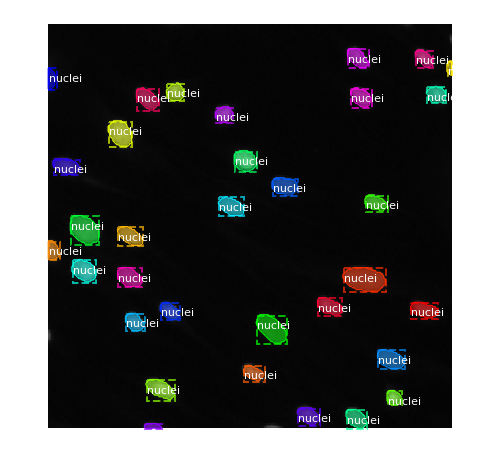

In [69]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_train.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [71]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

How it works in training dataset

Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  180.00000
molded_images            shape: (1, 256, 256, 3)      min: -121.70000  max:   76.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


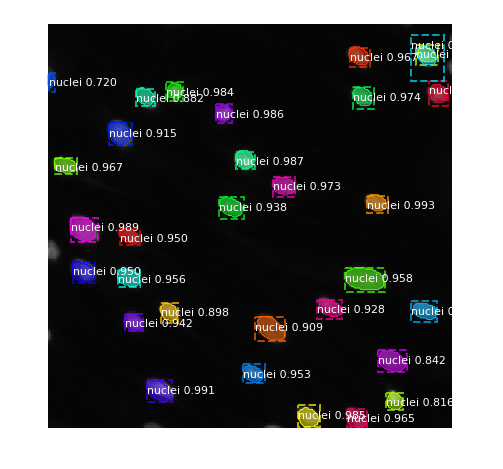

In [72]:
results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

How it works in validation dataset

/Users/yzu280/Documents/kaggle/Kaggle2018/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


{'id': 195, 'source': 'nuclei', 'path': './input/stage1_train/4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e/images/4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e.png', 'maskpath': './input/stage1_train/4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e/masks/'}
original_image           shape: (256, 256, 3)         min:    0.00000  max:  244.00000
image_meta               shape: (10,)                 min:    0.00000  max:  320.00000
gt_class_id              shape: (46,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (46, 4)               min:    0.00000  max:  256.00000
gt_mask                  shape: (256, 256, 46)        min:    0.00000  max:    1.00000


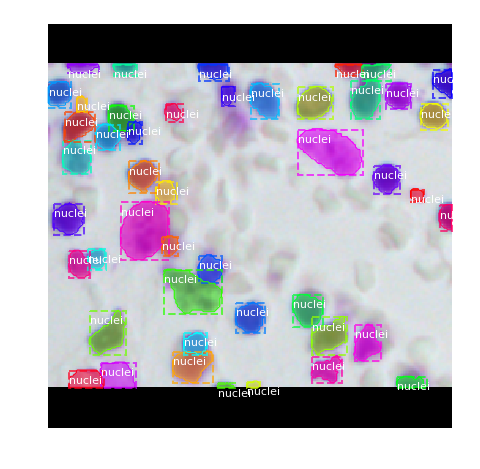

In [80]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
print(dataset_val.image_info[image_id])
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  244.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  140.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


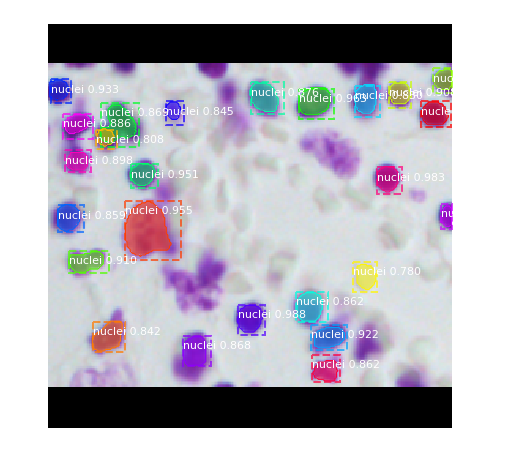

In [81]:
results = model.detect([original_image], verbose=1)

r = results[0]
#print(r)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [17]:
print()

/Users/yzu280/Documents/kaggle/Kaggle2018/logs/mask_rcnn_shapes_0313.h5
